<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/task1_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd
import seaborn as sns
import time

# **Data Preprocessing**

In [2]:
!gdown --fuzzy "https://drive.google.com/file/d/1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY/view?usp=drive_link"
!unzip /content/Dataset_1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Colorectal Cancer/MUS/MUS-CIHSSWPV.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIHWTRHA.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIILSKST.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIIMVVTT.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIITQWPP.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIKANVTM.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIKKELKA.tif  
  inflating: Colorectal Cancer/MUS/MUS-CILPKGCQ.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIMWFGFH.tif  
  inflating: Colorectal Cancer/MUS/MUS-CINGCMFK.tif  
  inflating: Colorectal Cancer/MUS/MUS-CINGLGES.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIPMCCVS.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIPNEIRF.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIQAGCRV.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIQFFGDI.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIRAICLW.tif  
  inflating: Colorectal Cancer/MUS/MUS-CISHTCWQ.tif  
  inflating: Colorectal Cancer/

In [3]:
dataset_dir = '/content/Colorectal Cancer'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_dir)

# Split dataset indices
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1)  # 10% of 80% = 8% of the whole

In [6]:
# Create subsets
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

In [7]:
# Apply transforms to subsets using a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [8]:
# Create a DataLoader for original images
batch_size = 64
original_dataset = CustomDataset(train_subset, transform=transform)
original_loader = DataLoader(original_dataset, batch_size=64, shuffle=False)

In [9]:
train_dataset = CustomDataset(train_subset, transform=transform)
val_dataset = CustomDataset(val_subset, transform=transform)
test_dataset = CustomDataset(test_subset, transform=transform)

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

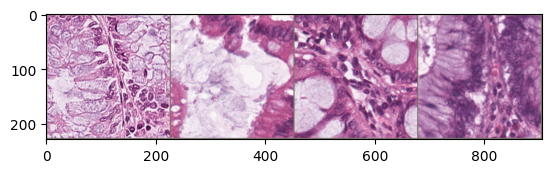

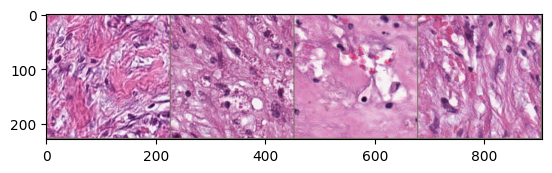

In [11]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Function to show images
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

# Fetch a batch of original images
images_original, _ = next(iter(original_loader))

# Fetch a batch of augmented images
images_augmented, _ = next(iter(train_loader))

# Display original images
imshow(torchvision.utils.make_grid(images_original[:4]))

# Display augmented images
imshow(torchvision.utils.make_grid(images_augmented[:4]))

# **Train the Model**

In [30]:
# Define ResNet-18 model
model = resnet18(weights = None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

In [31]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004083)

In [32]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
num_epochs = 21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#check the start time
training_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    epoch_start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #measure and print training time
    print(f'Epoch {epoch + 1} training time: {time.time() - epoch_start_time}' )

    # Validate the model
    model.eval()
    val_running_loss, val_correct, val_total  = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_outputs = model(images)
            val_loss = criterion(val_outputs, labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    # calculate validation loss and accuracy
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print training and validation metrics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

#print the total time
print("Total --- %s seconds ---" % (time.time() - training_start_time))

Epoch 1 training time: 19.762980937957764
Epoch 1/21, Train Loss: 0.7050, Train Accuracy: 75.97%, Validation Loss: 0.4551, Validation Accuracy: 83.96%
Epoch 2 training time: 20.86106586456299
Epoch 2/21, Train Loss: 0.3833, Train Accuracy: 85.23%, Validation Loss: 0.6609, Validation Accuracy: 72.29%
Epoch 3 training time: 19.925870895385742
Epoch 3/21, Train Loss: 0.3132, Train Accuracy: 88.26%, Validation Loss: 1.1192, Validation Accuracy: 72.92%
Epoch 4 training time: 20.06992220878601
Epoch 4/21, Train Loss: 0.2998, Train Accuracy: 89.72%, Validation Loss: 0.3070, Validation Accuracy: 88.75%
Epoch 5 training time: 20.185301780700684
Epoch 5/21, Train Loss: 0.3023, Train Accuracy: 89.10%, Validation Loss: 0.4235, Validation Accuracy: 84.58%
Epoch 6 training time: 19.780412673950195
Epoch 6/21, Train Loss: 0.2492, Train Accuracy: 90.93%, Validation Loss: 0.6048, Validation Accuracy: 83.33%
Epoch 7 training time: 20.25001358985901
Epoch 7/21, Train Loss: 0.1971, Train Accuracy: 92.94%,

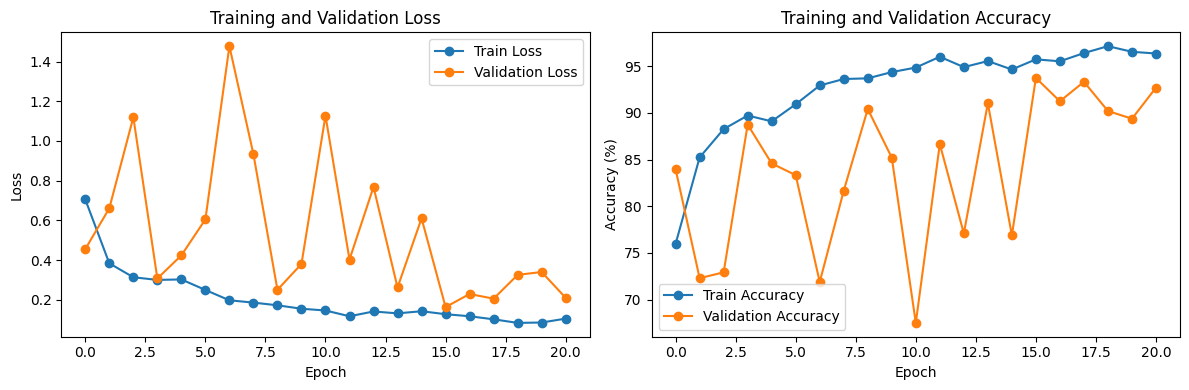

In [33]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ONLY RUN THIS IF YOU ARE TRAINING FOR THE FIRS TIME. IF YOU ALREADY HAVE A MODEL,
# DO NOT RUN THIS PART AGAIN.

#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/comp432/')

#torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/COMP432/Project/Project Implementation/final/resnet18_model.pth')

In [ ]:
#torch.save(model.state_dict(), 'resnet18_model.pth')

### Note (During the training the model)

### Try 1
-> train accuracy 64.02% at Epoch 10/10.

number of epoch = 10,

batch size = 64,

optimizer = SGD(with regularization - weight_decay),


### Try 2 - change the optimizer to adam & remove regularization(weight decay) and dropout layer
-> train accuracy 77.92% at Epoch 10/10.

optimizer = adam(without regularization),


### Try 3 - train with more epoch
->  train accuracy 88.98% at Epoch 20/20.

number of epoch = 20


### Try 4 - train the model with the best hyperparameter search with Orion
->  train accuracy 95.56% % at Epoch 19/19.

- best_hyperparmeters :
{ batchsize: 64, epochs: 19, lr: 0.001159 }





### Try 5 - train the model with repreprocessed data
->  train accuracy 95.56% % at Epoch 19/19.

- batch size : 32, learning rate = 0.001, opt = Adam

### Last Try - train the model with repreprocessed data +
hyperparameter search result
->  train accuracy 97.18% at Epoch 21/21
    validation accuracy 97.50% at Epoch 21/21

- batch size : 64, learning rate = 0.004083, epoch 21

-> Save the model as 'resnet18_model.pth'

# **Testing**
*Notice : To run the tesing code below, you are required to this:
1. Run all the code above EXCEPT those cells where the model is trained and saved. This is to load the testing data.
2. Go download the saved model in our shared folder.
3. Upload the pth file. Do not make any directory.


In [ ]:
# ADD SHORTCUT FROM COMP432 FOLDER TO YOUR COLAB NOTEBOOK FOLDER THEN ON THE LEFT HAND SIZE IN COLAB, UNDER "FILE", LOOK FOR THE PATH.
# LOAD THE MODEL

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#This cell is for the user who are using pre-trained model. If you have run the training loop above and model is already trained, you can skip
model = resnet18(weights = None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004083)

In [ ]:
#resnet18_model_98 is the best trained model.

state_dict = torch.load ('/content/resnet18_model_98.pth')
#in case you are curious what the weights look like ...
#print(state_dict)

In [ ]:
#match the pretrained weight in the initialized model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [34]:
# testing with the test dataset
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
running_loss = 0
total = 0
correct = 0

#to append the result
y_pred = []
y_test = []

#testing loop
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)
    y_test.append(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#for scikit learn classification report
y_pred_torch = torch.stack(y_pred[0:-1], dim=1)
y_test_torch = torch.stack(y_test[0:-1], dim=1)
y_pred_torch = y_pred_torch.cpu().detach().numpy()
y_test_torch = y_test_torch.cpu().detach().numpy()
y_pred_torch = np.reshape(y_pred_torch,(-1, 1))
y_test_torch = np.reshape(y_test_torch, (-1, 1))

target_names = ['MUS', 'NORM', 'STR']

#print metrics
print(classification_report(y_test_torch, y_pred_torch, target_names = target_names))
test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

              precision    recall  f1-score   support

         MUS       0.98      0.89      0.93       399
        NORM       0.99      0.92      0.95       386
         STR       0.84      0.99      0.91       367

    accuracy                           0.93      1152
   macro avg       0.94      0.93      0.93      1152
weighted avg       0.94      0.93      0.93      1152

Test Loss: 0.1920, Test Accuracy: 93.00%


In [35]:
#to append feature extraction and target
extracted_features = []
y_tsne = []

#remove last classification layer from our model
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

#loop
with torch.no_grad():
  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    features = newmodel(images)
    features = features.view(features.size(0), -1)
    extracted_features.append(features.cpu().numpy())
    y_tsne.append(labels)

# Concatenate all features to get the full feature set
extracted_features = np.concatenate(extracted_features, axis=0)
y_tsne = np.concatenate(y_tsne, axis=0)

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
tsne_result = tsne.fit_transform(extracted_features)

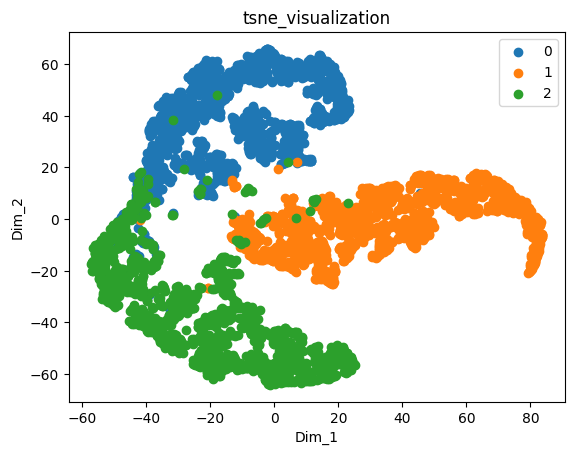

In [37]:
classes = list(set(y_tsne))
plt.figure()
for cl in classes:
  indices = np.where(y_tsne==cl)[0]
  plt.title('tsne_visualization')
  plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label = cl)
  plt.ylabel('Dim_2')
  plt.xlabel('Dim_1')
  plt.legend()